# VGG16 

## Data loading and preparation

In [ ]:
%tensorflow_version 1.x
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import random
from scipy.spatial import distance

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzipping the competition dataset...

In [ ]:
!unzip -q /content/drive/MyDrive/datasets/challenge_test_data.zip

In [ ]:
GALLERY_PATH = "/content/gallery"
QUERY_PATH = "/content/query"

## Model

We use the VGG16 model, pre-trained on imagenet.

In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 31s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). 

VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

## Loading images and preprocessing


We first define a function to load our data

In [ ]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3]) # load the image and resize it.
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

## Feature extraction

What we have in the model variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for our image retrieval task. Therefore we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called feat_extractor is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

In [ ]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

We now create the variables query_images and gallery_images, which are lists of paths of the various pictures.
Then, we will begin a loop which will open each image, extract its feature vector, and append it to two lists called query_features and gallery_features which will contain our activations for each image.

In [ ]:
image_extensions = ['.jpg', '.png', '.jpeg']

gallery_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(GALLERY_PATH) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("%d gallery images to analyze" % len(gallery_images))

6355 gallery images to analyze


In [ ]:
query_images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(QUERY_PATH) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
print("%d query images to analyze" % len(query_images))

65 query images to analyze


Now we use our feature extractor on our competition data. The predict function returns an array with one element per image. Each element contains a 4096-element array, which is the activations of the last fully-connected layer fc2 in VGG16.
We expect that the fc2 activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the fc2 activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In [ ]:
tic = time.clock()
query_features = []
for i, image_path in enumerate(query_images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(query_images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    query_features.append(feat)

print('finished extracting features for %d images' % len(query_images))

analyzing image 0 / 65. Time: 0.0003 seconds.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


finished extracting features for 65 images


In [ ]:
tic = time.clock()
gallery_features = []
for i, image_path in enumerate(gallery_images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(gallery_images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    gallery_features.append(feat)

print('finished extracting features for %d images' % len(gallery_images))

analyzing image 0 / 6355. Time: 0.0002 seconds.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


analyzing image 500 / 6355. Time: 4.3336 seconds.
analyzing image 1000 / 6355. Time: 4.3342 seconds.
analyzing image 1500 / 6355. Time: 4.4377 seconds.
analyzing image 2000 / 6355. Time: 4.3283 seconds.
analyzing image 2500 / 6355. Time: 4.3939 seconds.
analyzing image 3000 / 6355. Time: 4.6657 seconds.
analyzing image 3500 / 6355. Time: 4.4756 seconds.
analyzing image 4000 / 6355. Time: 4.8014 seconds.
analyzing image 4500 / 6355. Time: 4.4307 seconds.
analyzing image 5000 / 6355. Time: 4.8214 seconds.
analyzing image 5500 / 6355. Time: 4.3899 seconds.
analyzing image 6000 / 6355. Time: 4.7215 seconds.
finished extracting features for 6355 images


We are now ready to do our reverse image queries. Both query_features and gallery_features contain a compact representation of our images, one 4096-element row for each image. The assumption we can now make is that two images which have similar content, should produce similar feature vectors.
In order to do image retrieval, though, we first need to decide a measurement of the distance between each query feature vector and all the gallery ones. We choose to use both euclidean distance and cosine similarity.

The list idx_closest contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. Then we sort them, finding the most similar items, and returning the indexes of the 10 most similar images. 
Since our wanted output is a dictionary, we define the function get_closest_dict, whose key-value pairs are composed by the path of the query image and the list of the ten most similar gallery images.

In [ ]:
def get_closest_images_cosine(query_image_idx, query_features, gallery_features, num_results=10):
    distances = [ distance.cosine(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest

def get_closest_images_euclidean(query_image_idx, query_features, gallery_features, num_results=10):
    distances = [ distance.euclidean(query_features[query_image_idx], feat) for feat in gallery_features]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[:num_results]
    return idx_closest


In [ ]:
def get_closest_dict(query_images, gallery_images, query_features, gallery_features, distance = 'cosine'):
  res = {}
  for i in range(len(query_images)):

    if distance == 'euclidean':
      idx_closest = get_closest_images_euclidean(i, query_features, gallery_features)
    else:
      idx_closest = get_closest_images_cosine(i, query_features, gallery_features)
      
    closest_images_list = [gallery_images[idx] for idx in idx_closest]
    res[query_images[i]] = closest_images_list

  return res


In [ ]:
dizionario = get_closest_dict(query_images, gallery_images, 'cosine')


In [ ]:
from pprint import pprint
pprint(dizionario)

{'/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg': ['/content/gallery/0e6498edcff0e72806cbc68cee1ae886e40f526c.jpg',
                                                                 '/content/gallery/8af2677cccaf16fd4373166fe148a7c842f7ba59.jpg',
                                                                 '/content/gallery/a53c8107acc5c49fb0d70416312b69cbb3fa8b43.jpg',
                                                                 '/content/gallery/367305c879da423477c25714abaa99812ceee04b.jpg',
                                                                 '/content/gallery/30df80060dd706ff273bb4e305380d7e77938a46.jpg',
                                                                 '/content/gallery/07e60e76c66f825d57eed65973e12ae6af728b7a.jpg',
                                                                 '/content/gallery/16431a6490921dbb9787b9a968bde33d05b8d55c.jpg',
                                                                 '/content/gallery/1ec6b5a

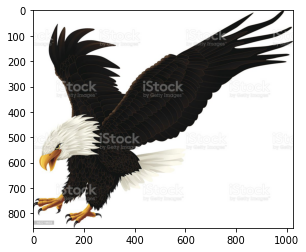

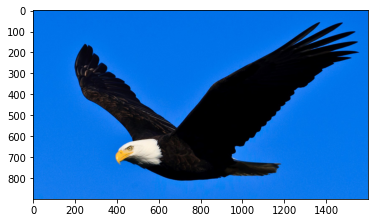

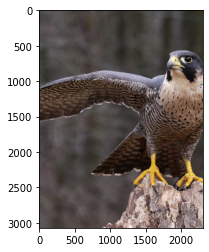

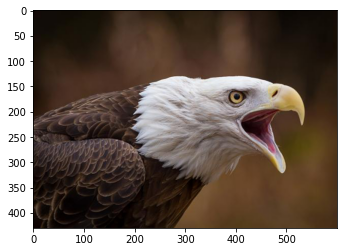

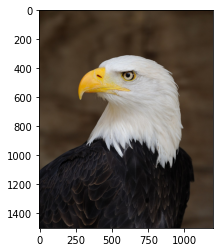

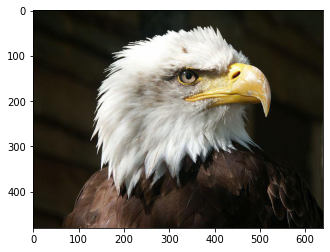

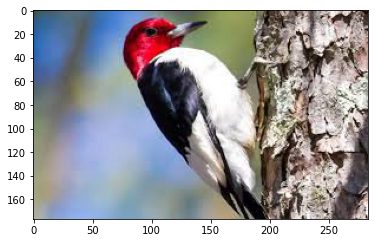

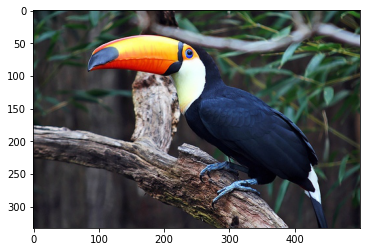

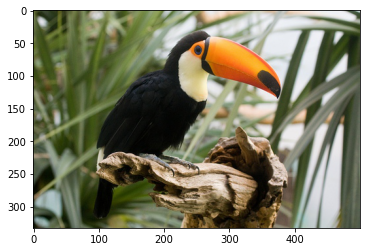

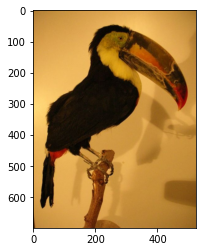

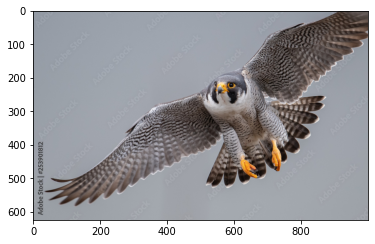

In [ ]:
### Printing the first query and its matches
print("##### QUERY #####")
plt.imshow(plt.imread('/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg'))
plt.show()
print('\n\n')
print('##### MATCHES #####')

for similar_image in dizionario['/content/query/013c80f43deff8d61b6a2021f9b0a335665fdd1f.jpg']:
  plt.imshow(plt.imread(similar_image))
  plt.show()
  print('\n')

So, we are done with our image retrieval task. Nonetheless, we want to try also to do something more on top of this.
In particular, we would like to apply a PCA algorithm on the 4096-element feature vector to try to reduce the dimensionality of our feature vectors down to 30. This is for two reasons: 
1) the 4096 feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 
2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation.
3) We are also interested in seeing how much our retrieval performance decreases when we go from a 4096-element vector to a 30-element one. As a matter of fact, we are decreasing our vector size by a factor of 128!

The next cell will instantiate a PCA object, which we will then fit our data to, choosing to keep the top 30 principal components.

In [ ]:
query_features = np.array(query_features)
pca = PCA(n_components=30)
pca.fit(query_features)

PCA(n_components=30)

In [ ]:
gallery_features = np.array(gallery_features)
pca = PCA(n_components=30)
pca.fit(gallery_features)

PCA(n_components=30)

The pca object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 30-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [ ]:
query_pca_features = pca.transform(query_features)

In [ ]:
gallery_pca_features = pca.transform(gallery_features)

In [ ]:
dizionario = get_closest_dict(query_images, gallery_images, query_pca_features, gallery_pca_features, 'cosine')

We can try again to do this process using euclidean distance instead of cosine similarity.